In [ ]:
#CNN for image extraction
#LSTM for natural language processing

IMPORT THE NECESSARY LIBRARIES


In [ ]:
import numpy as np
import pandas as pd
import os #os => for handling files
import pickle #pickle => get use numpy features. serialization(converting the objects into stream of bytes so that it can be persisted/transported) and deserialization
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm #provides a fast, extensible progress bar for loops and other iterable operations
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences #to even out the sentences.
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional # RNN MODEL
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201  # CNN MODEL
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

IMPORTING THE DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Images:

In [ ]:
image_path = '/content/drive/MyDrive/csv/FoDS/PROJECT/visuallyimpair/visual_dataset' #ALL IMAGES

Captions:

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/csv/FoDS/PROJECT/visuallyimpair/visual_text/visual.token.txt")

df.columns.values[0] ="Images"
df=df.Images.str.split("#",expand=True)
df.columns=['Images','Captions']
df['Captions']=df['Captions'].str.replace('[0-9]\t', '')
df.head()

Images                    Captions
0  greensig1.jpg  Green signal please walk .
1  greensig1.jpg  Green signal please walk .
2  greensig1.jpg  Green signal please walk .
3  greensig1.jpg  Green signal please walk .
4  greensig2.jpg  Green signal please walk .

In [ ]:
def readImage(path,img_size=224): #target height and width pixels
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img) # convert image data to numpy array
    img = img/255.  # normalize the to the range (0,1).

    return img

def display_images(temp_df):  # to display the images using the plots and mentioning the captions along with it.
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n) #subplot having n rows, n columns, nth index onward
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/csv/FoDS/PROJECT/visuallyimpair/visual_dataset/{temp_df.Images[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.Captions[i], 20)))
        plt.axis("off")

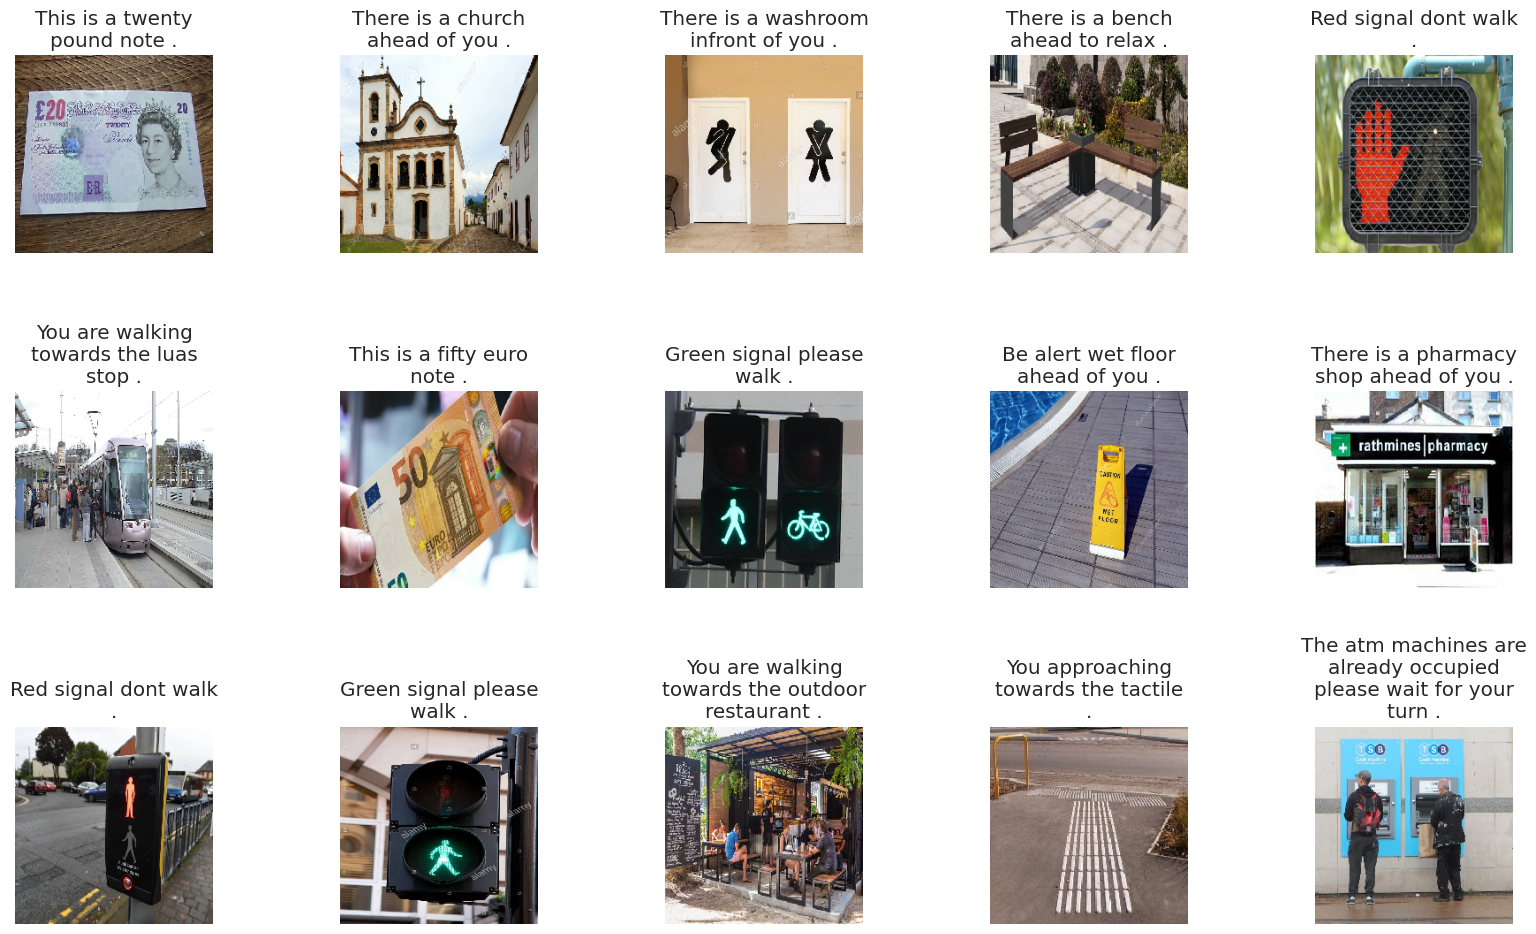

In [ ]:
display_images(df.sample(15))

In [ ]:
def preprocess_text(df):  # preprocessing the text by removing the  special characters and converting them to lower case letters
    df['Captions'] = df['Captions'].str.lower() # converting to lower case
#     df['Captions'] = df['Captions'].str.replace('[^A-Za-z]', '') # removing all the characters other than the alphabets
#     df['Captions'] = df['Captions'].str.replace('\s+', ' ') # if the captions have multiple spaces
    df['Captions'] = "startseq "+df['Captions']+" endseq" # adding a start and end tag to the caption and to remove the words which have a single letter in their caption
    return df

In [ ]:
df=preprocess_text(df)

In [ ]:
df

Images                                           Captions
0     greensig1.jpg         startseq green signal please walk . endseq
1     greensig1.jpg         startseq green signal please walk . endseq
2     greensig1.jpg         startseq green signal please walk . endseq
3     greensig1.jpg         startseq green signal please walk . endseq
4     greensig2.jpg         startseq green signal please walk . endseq
...             ...                                                ...
7994  playing50.jpg     startseq kids are playing in the park . endseq
7995  playing50.jpg     startseq kids are sitting in the park . endseq
7996  playing50.jpg   startseq kids are sitting in the garden . endseq
7997  playing50.jpg  startseq group of kids sitting in the park . e...
7998  playing50.jpg  startseq group of kids sitting and playing in ...

[7999 rows x 2 columns]

In [ ]:
#separate list with only captions
captions = []
for caption in df['Captions']:
        captions.append(caption)

In [ ]:
captions[:10]

['startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq']

In [ ]:
# tokenize the text - splitting into words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions) # mapping each UNIQUE word in the captions to a NUMERICAL index.
vocab_size = len(tokenizer.word_index) + 1  # total vocab size(no. of tokens)

# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in captions)

############################################################################################

images = df['Images'].unique().tolist()
images_no = len(images)

split_index = round(0.80*images_no) # considering 80 20 split
train_images = images[:split_index] # trained images
val_images = images[split_index:] # test images

train =df[df['Images'].isin(train_images)]  # checks if the images are present in train array
test = df[df['Images'].isin(val_images)]  #checks if the images are present in test array

train.reset_index(inplace=True,drop=True) # start with the deafult index value (0,1,2..)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]  #captions --> sequence of integers from TOKENIZATION STEP


print("Vocab Size is :",vocab_size)
print("Max Lenght is :",max_length)


Vocab Size is : 150
Max Lenght is : 18


IMAGE FEATURE EXTRACTION

In [ ]:
#load VGG16 model. PRE-TRAINED CNN MODEL FOR IMAGE EXTRACTION,
model = VGG16() # CNN model that uses convolutional layers (13 convolutional + 3 fully connected layers)

# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)  #REMOVING LAST CLASSIFICATION LAYER - only want the feature representation


553467096/553467096 [==============================] - 4s 0us/step


In [ ]:
img_size = 224

features = {} #key --> image id ; value --> to be EXTRACTED features in that img

# Iterate through files in the directory
# Construct the full path to the image
for image in tqdm(df['Images'].unique().tolist()):
    # Load and preprocess the image
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))  #PIL Image object represents the loaded and resized image.
    img = img_to_array(img)  #(height, width, channels) #3 channels for RGB
    img = img/255. #normalizing (0,1)
    img = np.expand_dims(img,axis=0)  #(1, height, width, channels). The first dimension (axis 0) represents the BATCH size

# Extract features using the model
    feature = model.predict(img, verbose=0)
# Store feature in the dictionary
    features[image] = feature

#Each element in the feature vector captures certain visual patterns, textures, and spatial hierarchies detected by the CNN

  0%|          | 0/1600 [00:00<?, ?it/s]

In [ ]:
#BATCH/training sample consists of an image feature, an input sequence, and the corresponding output sequence
#model learns by predicting the next word in the sequence.

class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col   #will be the image id
        self.y_col = y_col   #will be the captions
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features  # Dictionary containing image features (extracted from VGG16).
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):  #Shuffles the data at the end of each epoch. to introduce randomness into the order of the training data during each epoch of training
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):  #one batch of data retrieved.

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):
#Loops over an image's EXTRACTED FEATURES and ASSOCIATIED CAPTIONS, tokenizes the captions, and prepares input-output pairs FOR TRAINING

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [ ]:
input1 = Input(shape=(4096,))  #image features with vector size 4096 []DENSE LAYER OF CNN CONTAINS 4096 NUERONS]
input2 = Input(shape=(max_length,))  #sequences (captions) with shape (max_length,)

#Avoiding Vanishing Gradient Problem:
#During backpropagation, gradients  of the loss function with respect to the parameters (weights and biases) can become very small making it difficult for the model to learn.
#ReLU's gradient is either zero or one, making it less prone to this issue.

img_features = Dense(256, activation='relu')(input1) #Rectified Linear Unit
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features) #It adds an extra dimension to represent the sequence length of 1.

                    #embedding caption into dense vectors.
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
# zero-padding in the input sequences should not be masked during training.

#merging (reshped images + embedded sentences)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged) #256 UNITS
#dropout -  prevent overfitting by randomly setting a fraction of input units to zero during training.
x = Dropout(0.5)(sentence_features)
#output of the dropout layer (x) is added element-wise to the reshaped image features
x = add([x, img_features])
x = Dense(128, activation='relu')(x) #128 UNITS
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x) #SOFTMAX - OUTPUT PROBABILITY OF NEXT WORD IN THE CAPTION

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

#loss function for multiclass classification problems, where each input belongs to exactly one class.
#to adjust the weights of the neural network during training, based on the gradients of the loss function with respect to the weights.
#'adam' optimizer adaptively adjust learning rates for each parameter.

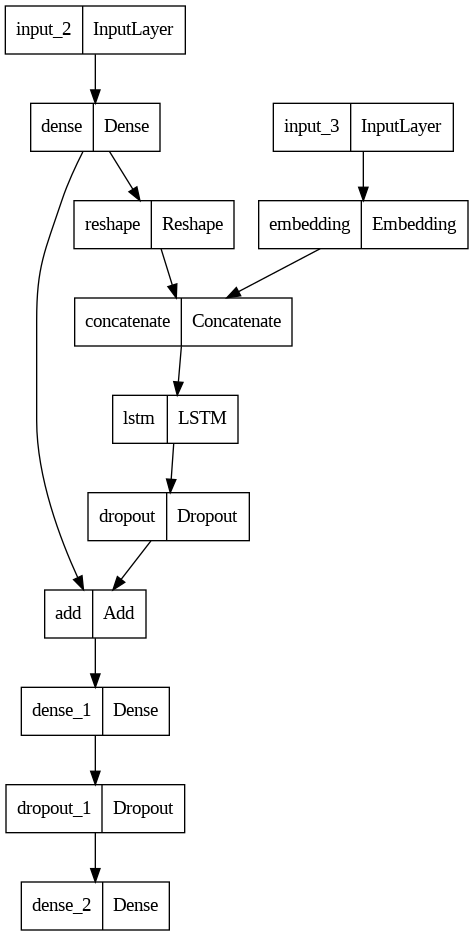

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(caption_model)

In [ ]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  1048832   ['input_2[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 18)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 256)               0         ['dense[0][0]']               
                                                                                            

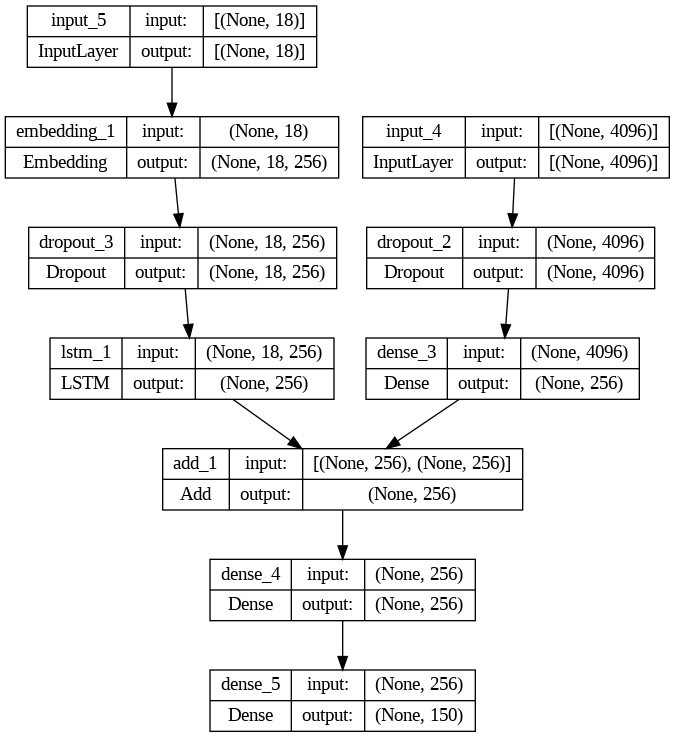

In [ ]:
input1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(input1)
img_features = Dense(256, activation='relu')(fe1)
#img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

input2 = Input(shape=(max_length,))
sentence_features = Embedding(vocab_size, 256, mask_zero=True)(input2)
se2 = Dropout(0.425)(sentence_features)
se3 = LSTM(256)(se2)

#merged = concatenate([img_features_reshaped,sentence_features],axis=1)
#sentence_features = LSTM(256)(merged)
#x = Dropout(0.5)(sentence_features)
#x = add([x, img_features])
#x = Dense(128, activation='relu')(x)
#x = Dropout(0.5)(x)
#output = Dense(vocab_size, activation='softmax')(x)

#caption_model = Model(inputs=[input1,input2], outputs=output)
#caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

decoder1 = add([img_features,se3])
decoder2 = Dense(256, activation='relu')(decoder1)
output = Dense(vocab_size,activation='softmax')(decoder2)

model = Model(inputs=[input1,input2],outputs=output)
model.compile(loss='categorical_crossentropy',optimizer='adam')

plot_model(model,show_shapes=True)

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='Images',y_col='Captions',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='Images',y_col='Captions',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
#whenever the validation loss (val_loss) decreases. The saved model corresponds to the one with the best performance on the validation set.
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

# earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)


#reduces the learning rate when val loss stopped improving. The learning rate is reduced by a factor of 0.2 after a certain number of epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator)
#         callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/10
99/99 [==============================] - 455s 5s/step - loss: 4.2332 - val_loss: 4.7558
Epoch 2/10
99/99 [==============================] - 107s 1s/step - loss: 2.9839 - val_loss: 4.8489
Epoch 3/10
99/99 [==============================] - 93s 937ms/step - loss: 1.7057 - val_loss: 5.6546
Epoch 4/10
99/99 [==============================] - 104s 1s/step - loss: 1.0419 - val_loss: 6.6313
Epoch 5/10
99/99 [==============================] - 93s 937ms/step - loss: 0.7611 - val_loss: 7.3017
Epoch 6/10
99/99 [==============================] - 96s 966ms/step - loss: 0.6201 - val_loss: 7.5505
Epoch 7/10
99/99 [==============================] - 95s 960ms/step - loss: 0.5403 - val_loss: 8.0691
Epoch 8/10
99/99 [==============================] - 94s 949ms/step - loss: 0.4935 - val_loss: 8.2103
Epoch 9/10
99/99 [==============================] - 104s 1s/step - loss: 0.4613 - val_loss: 8.8484
Epoch 10/10
99/99 [==============================] - 103s 1s/step - loss: 0.4349 - val_loss: 8.2871

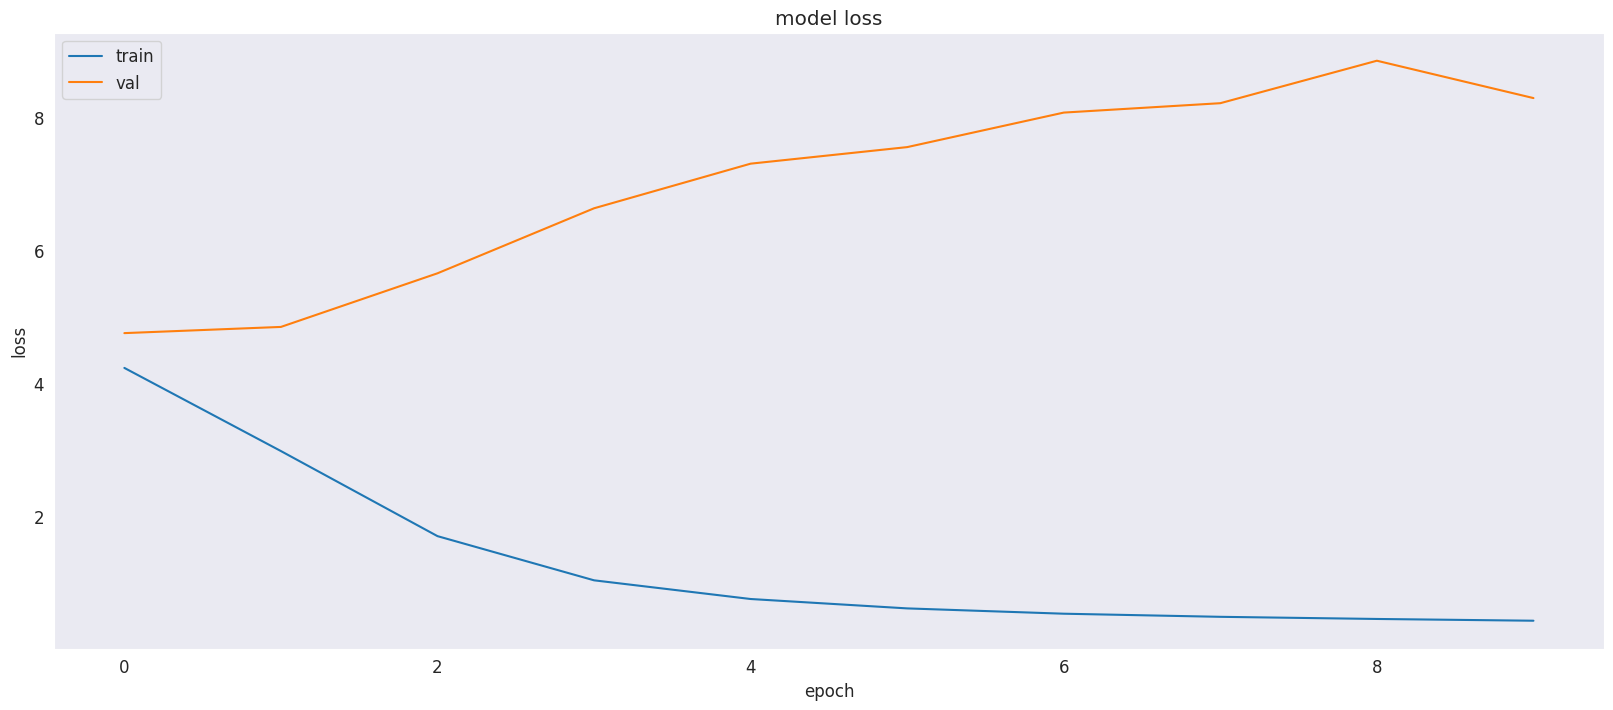

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#token index to word

def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [ ]:
samples = train.sample(15)  # checking for 15 sample images from the dataset
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['Images']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['Images'], tokenizer, max_length, features)
    samples.loc[index,'Captions'] = caption

1/1 [==============================] - 0s 26ms/step


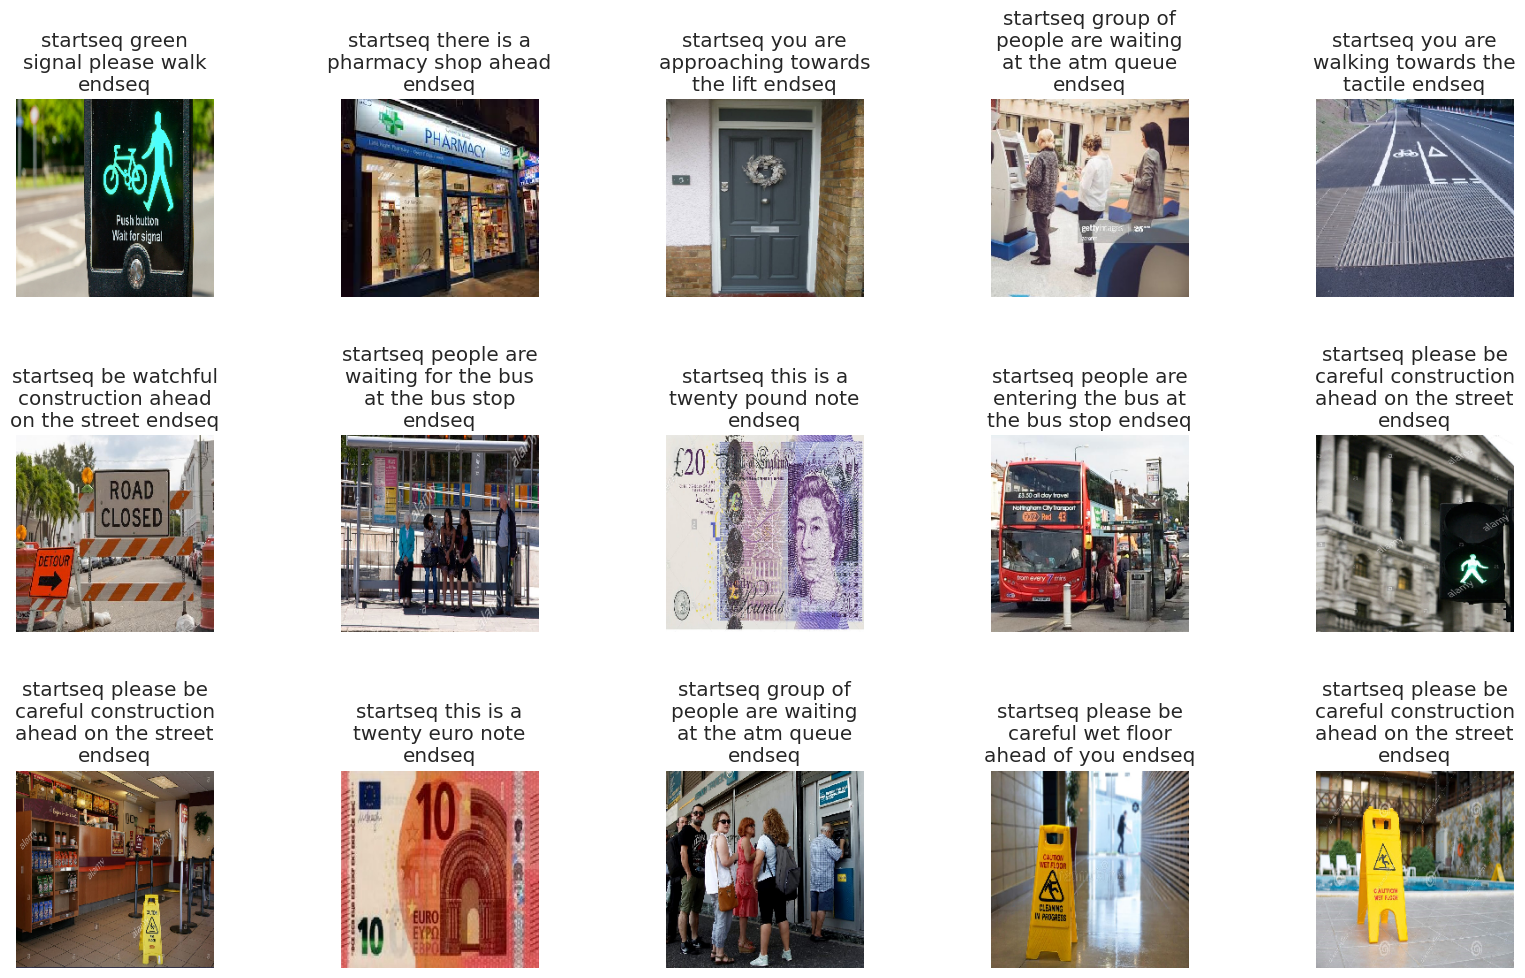

In [ ]:
display_images(samples)

Unigram (BLEU-1) only: weights = (1.0, 0, 0, 0)

Equal weight for unigrams and bigrams (BLEU-2): weights = (0.5, 0.5, 0, 0)

Equal weight for unigrams, bigrams, and trigrams (BLEU-3): weights = (0.33, 0.33, 0.33, 0)

Equal weight for unigrams, bigrams, trigrams, and 4-grams (BLEU-4): weights = (0.25, 0.25, 0.25, 0.25)

Give more weight to bigrams and trigrams (custom weights): weights = (0.1, 0.6, 0.3, 0)

Only consider bigrams and trigrams (custom weights): weights = (0, 0.7, 0.3, 0)

In [ ]:
#BILINGUAL EVALUATION UNDERSTUDY
#evaluates the precision of n-grams (contiguous sequences of n items, typically words) in the machine-generated translation compared to reference translations.

from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = df['Captions']
    # predict the caption for image
    y_pred = predict_caption(caption_model, record['Images'], tokenizer, max_length, features)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

print("BLEU-5: %f" % corpus_bleu(actual, predicted, weights=(0.1, 0.6, 0.3, 0)))
print("BLEU-6: %f" % corpus_bleu(actual, predicted, weights=(0, 0.7, 0.3, 0)))

  0%|          | 0/1600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 1/1600 [00:01<30:22,  1.14s/it]

1/1 [==============================] - 0s 41ms/step


  0%|          | 2/1600 [00:02<30:45,  1.16s/it]


BLEU-1: 1.000000
BLEU-2: 0.942809
BLEU-3: 0.920412
BLEU-4: 0.903602
BLEU-5: 0.895181
BLEU-6: 0.884699


1/1 [==============================] - 0s 30ms/step


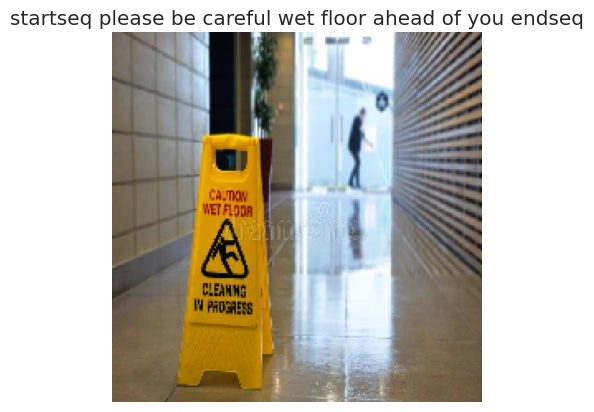

In [ ]:
image_filename = 'wetfloor49.jpg'

# Load the image
img = load_img(os.path.join(image_path, image_filename), target_size=(224, 224))
img_array = img_to_array(img)
img_array = img_array / 255.

# Make predictions for the single image
caption = predict_caption(caption_model, image_filename, tokenizer, max_length, features)

# Display the image
plt.imshow(img_array)
plt.title(caption)
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 43ms/step


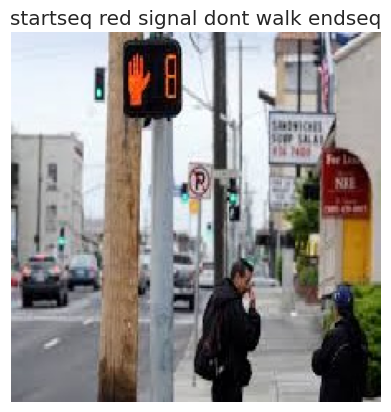

In [ ]:
image_filename = 'redsig56.jpg'

# Load the image
img = load_img(os.path.join(image_path, image_filename), target_size=(224, 224))
img_array = img_to_array(img)
img_array = img_array / 255.

# Make predictions for the single image
caption = predict_caption(caption_model, image_filename, tokenizer, max_length, features)

# Display the image
plt.imshow(img_array)
plt.title(caption)
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 29ms/step


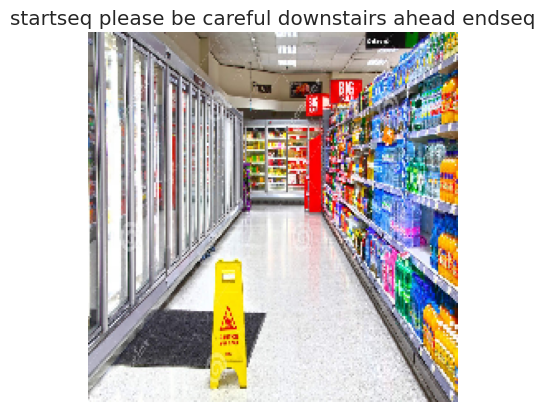

In [ ]:
image_filename = 'wetfloor47.jpg'

# Load the image
img = load_img(os.path.join(image_path, image_filename), target_size=(224, 224))
img_array = img_to_array(img)
img_array = img_array / 255.

# Make predictions for the single image
caption = predict_caption(caption_model, image_filename, tokenizer, max_length, features)

# Display the image
plt.imshow(img_array)
plt.title(caption)
plt.axis('off')
plt.show()


In [ ]:
pip install rouge

'rouge-1': Represents ROUGE-1, which measures the overlap of unigrams (single words) between the predicted and reference text.

'rouge-2': Represents ROUGE-2, which measures the overlap of bigrams (consecutive pairs of words) between the predicted and reference text.

'rouge-l': Represents ROUGE-L, which measures the overlap of the longest common subsequence between the predicted and reference text.

In [ ]:
from rouge import Rouge
from tqdm import tqdm

# validate with test data
rouge = Rouge()
scores = {'rouge-1': 0.0, 'rouge-2': 0.0, 'rouge-l': 0.0}

actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = df['Captions']
    # predict the caption for image
    y_pred = predict_caption(caption_model, record['Images'], tokenizer, max_length, features)
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

    # Calculate ROUGE scores
    rouge_scores = rouge.get_scores(y_pred, caption)

    print(rouge_scores)

    # Update cumulative scores
    scores['rouge-1'] += rouge_scores[0]['rouge-1']['f']
    scores['rouge-2'] += rouge_scores[0]['rouge-2']['f']
    scores['rouge-l'] += rouge_scores[0]['rouge-l']['f']

# Average the scores
num_samples = len(test)
scores['rouge-1'] /= num_samples
scores['rouge-2'] /= num_samples
scores['rouge-l'] /= num_samples

print("ROUGE-1: %f" % scores['rouge-1'])
print("ROUGE-2: %f" % scores['rouge-2'])
print("ROUGE-L: %f" % scores['rouge-l'])


  0%|          | 0/1600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 82ms/step


  0%|          | 1/1600 [00:02<1:05:19,  2.45s/it]

[{'rouge-1': {'r': 0.3333333333333333, 'p': 0.2, 'f': 0.24999999531250006}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.3333333333333333, 'p': 0.2, 'f': 0.24999999531250006}}]
1/1 [==============================] - 0s 94ms/step


  0%|          | 2/1600 [00:04<58:05,  2.18s/it]

[{'rouge-1': {'r': 0.3333333333333333, 'p': 0.2, 'f': 0.24999999531250006}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.3333333333333333, 'p': 0.2, 'f': 0.24999999531250006}}]
ROUGE-1: 0.000312
ROUGE-2: 0.000000
ROUGE-L: 0.000312
